This is a notebook explaining the [Ink Detection progress prize on Kaggle](https://www.kaggle.com/competitions/vesuvius-challenge), which is part of the larger [Vesuvius Challenge](https://scrollprize.org).

For more background on the process of ink detection, be sure to check out [Tutorial 4: Ink Detection](https://scrollprize.org/tutorial4) on the Vesuvius Challenge website.

In this notebook we'll see how to train a simple ML model to detect ink in a papyrus fragment from a 3d x-ray scan of the fragment.

<img src="https://user-images.githubusercontent.com/177461/224853397-3cf86dc2-45b4-4e7c-9ec2-28a733791a75.jpg" width="200"/>

First, initialize some variables, and let's look at a photo of the fragment. We won't use this for training, but it's useful to see.

It's an infrared photo, since the ink is better visible in infrared light.

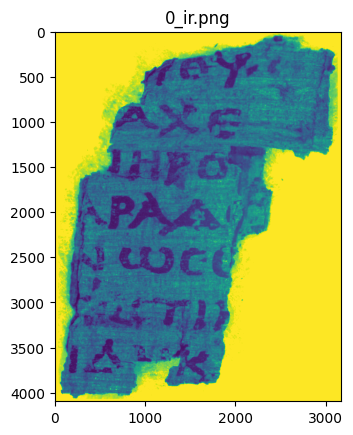

/home/stu/anaconda3/envs/dtt/lib/python3.9/site-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (140973980 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


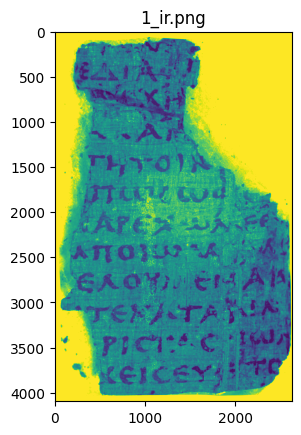

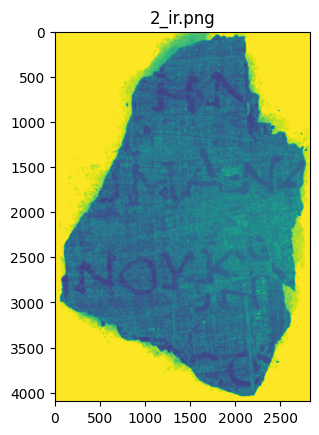

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import glob
import PIL.Image as Image
import torch.utils.data as data
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tqdm import tqdm
from ipywidgets import interact, fixed
from torch.utils.tensorboard import SummaryWriter
from torchvision.utils import make_grid
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

PREFIX = ['data/train/1/', 'data/train/2/', 'data/train/3/']
TEST_PREFIX = ['data/test/a/', 'data/test/b/']
BUFFER = 30  # Buffer size in x and y direction
Z_START = 27 # First slice in the z direction to use
Z_DIM = 10  # Number of slices in the z direction
TRAINING_STEPS = 60000
SHARED_HEIGHT = 4096
LEARNING_RATE = 1e-3
BATCH_SIZE =  32
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
IS_TRAIN = True
CHEPOINT = 'result/[train_loss]-0.1417-[dice_score]-0.0325-[iou_score]-0.0165-0-epoch.pkl'
FT = False # 是否加载预训练权重
THRESHOLD = 0.5 # mask阈值


def resize(img):
    current_width, current_height = img.size
    aspect_ratio = current_width / current_height
    new_width = int(SHARED_HEIGHT * aspect_ratio)
    new_size = (new_width, SHARED_HEIGHT)
    img = img.resize(new_size)
    return img
def img_concat(img_list):
    width = []
    height = []
    for i in img_list:
        width.append(i.width)
        height.append(i.height)
    target = Image.new('RGB', (sum(width), SHARED_HEIGHT))  #拼接前需要写拼接完成后的图片大小
    for i in range(len(img_list)):
        x = sum(width[:i])            # 图片距离左边的大小
        y = 0                         # 图片距离上边的大小
        w = x + width[i]              # 图片距离左边的大小 + 图片自身宽度
        h = y + height[i]             # 图片距离上边的大小 + 图片自身高度
        target.paste(img_list[i], (x, y, w, h))
    return target

for i in range(len(PREFIX)):
    fig, ax1 = plt.subplots(1, 1)
    ax1.set_title(str(i) + "_ir.png")
    ax1.imshow(resize(Image.open(PREFIX[i] + 'ir.png')))
    plt.show()

Let's load these binary images:
* **mask.png**: a mask of which pixels contain data, and which pixels we should ignore.
* **inklabels.png**: our label data: whether a pixel contains ink or no ink (which has been hand-labeled based on the infrared photo).

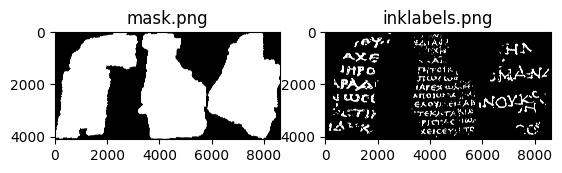

In [2]:
if IS_TRAIN:
    # 加载训练数据
    mask_list = []
    lable_list = []
    for i in range(len(PREFIX)):
        mask = resize(Image.open(PREFIX[i]+"mask.png"))
        label = resize(Image.open(PREFIX[i]+"inklabels.png"))
        mask_list.append(mask)
        lable_list.append(label)
    mask_all = np.array(img_concat(mask_list).convert('1'))
    label_all = torch.from_numpy(np.array(img_concat(lable_list).convert('1'))).gt(0).float().to(DEVICE)
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.set_title("mask.png")
    ax1.imshow(mask_all, cmap='gray')
    ax2.set_title("inklabels.png")
    ax2.imshow(label_all.cpu(), cmap='gray')
    plt.show()
    del mask_list
    del lable_list

Next, we'll load the 3d x-ray of the fragment. This is represented as a .tif image stack. The image stack is an array of 16-bit grayscale images. Each image represents a "slice" in the z-direction, going from below the papyrus, to above the papyrus. We'll convert it to a 4D tensor of 32-bit floats. We'll also convert the pixel values to the range [0, 1].

To save memory, we'll only load the innermost slices (`Z_DIM` of them). Let's look at them when we're done.

100%|██████████| 16/16 [00:03<00:00,  4.83it/s]


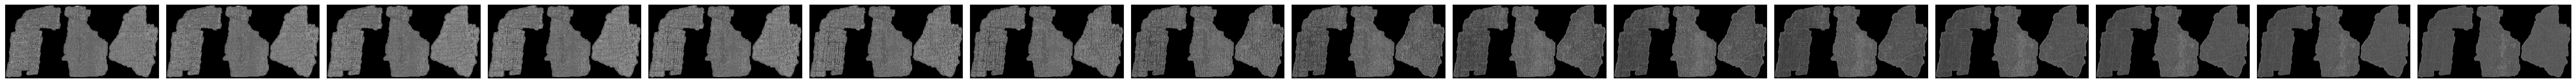

In [3]:
# Load the 3d x-ray scan, one slice at a time
if IS_TRAIN:
  image_stack_all = []
  for i in range(len(PREFIX)):
    # Load the 3d x-ray scan, one slice at a time
    z_slices = []
    for filename in tqdm(sorted(glob.glob(PREFIX[i]+"surface_volume/*.tif"))[Z_START:Z_START+Z_DIM]):
        img = Image.open(filename)
        img = resize(img)
        z_slice = torch.from_numpy(np.array(img, dtype="float32")/65535.0)
        z_slices.append(z_slice)
    z_slices = torch.stack(z_slices, axis=-1)
    image_stack_all.append(z_slices)
  image_stack_all = torch.concat(image_stack_all, dim=1).to(DEVICE)
  # fig, axes = plt.subplots(1, image_stack_all.shape[2])
  # for z, ax in enumerate(axes):
  #   ax.imshow(image_stack_all[:, :, z], cmap='gray')
  #   ax.set_xticks([]); ax.set_yticks([])
  # fig.tight_layout()
  # plt.show()
  image_stack_all = image_stack_all.permute(2, 0, 1)
  fig, axes = plt.subplots(1, image_stack_all.shape[0], figsize=(50, 25))
  for image, ax in zip(image_stack_all.cpu().numpy(), axes):
      ax.imshow(np.array(image, dtype=np.float32), cmap='gray')
      ax.set_xticks([]); ax.set_yticks([])
  fig.tight_layout()
  plt.show()

Can you see the ink in these slices of the 3d x-ray scan..? Neither can we.

Now we'll create a dataset of subvolumes. We use a small rectangle around the letter "P" for our evaluation, and we'll exclude those pixels from the training set. (It's actually a Greek letter "rho", which looks similar to our "P".)

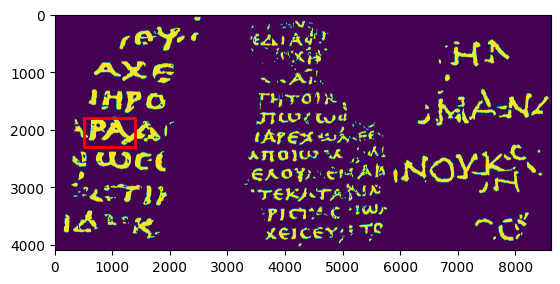

In [4]:
if IS_TRAIN:
    rect = (500, 1800, 900, 500)
    fig, ax = plt.subplots()
    ax.imshow(label_all.cpu())
    patch = patches.Rectangle((rect[0], rect[1]), rect[2], rect[3], linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(patch)
    plt.show()

Now we'll define a PyTorch dataset and (super simple) model.

In [5]:
def sample_random_location(shape):
    random_train_x = torch.random.uniform(shape=(), minval=BUFFER, maxval=shape[0] - BUFFER - 1, dtype="int32")
    random_train_y = torch.random.uniform(shape=(), minval=BUFFER, maxval=shape[1] - BUFFER - 1, dtype="int32")
    random_train_location = torch.stack([random_train_x, random_train_y])
    return random_train_location
class SubvolumeDataset(data.Dataset):
    def __init__(self, image_stack, label, pixels, is_train=False, is_val=False):
        self.image_stack = image_stack
        self.label = label
        self.pixels = pixels
        self.is_train = is_train
        self.is_val = is_val
    def __len__(self):
        return len(self.pixels)
    def __getitem__(self, index):
        # if self.is_train and not self.is_val:
        #     index = torch.randint(0, len(self.pixels) - 1,[1])
        #     y, x = self.pixels[index[0]]
        # else:
        y, x = self.pixels[index]
        subvolume = self.image_stack[:, y-BUFFER:y+BUFFER+1, x-BUFFER:x+BUFFER+1].view(1, Z_DIM, BUFFER*2+1, BUFFER*2+1)
        if self.is_train:
            inklabel = self.label[y, x].view(1)
            return subvolume, inklabel
        else:
            return subvolume
# IOU and Dice Score
def dice_coef(y_true, y_pred, thr=0.5, dim=(0, 1), epsilon=0.001):
    y_true = y_true.to(torch.float32)
    y_pred = (y_pred > thr).to(torch.float32)
    inter = (y_true * y_pred).sum(dim=dim)
    den = y_true.sum(dim=dim) + y_pred.sum(dim=dim)
    dice = ((2 * inter + epsilon) / (den + epsilon)).mean()
    return dice


def iou_coef(y_true, y_pred, thr=0.5, dim=(0, 1), epsilon=0.001):
    y_true = y_true.to(torch.float32)
    y_pred = (y_pred > thr).to(torch.float32)
    inter = (y_true * y_pred).sum(dim=dim)
    union = (y_true + y_pred - y_true * y_pred).sum(dim=dim)
    iou = ((inter + epsilon) / (union + epsilon)).mean()
    return iou

# model = nn.Sequential(
#     nn.Conv3d(1, 16, 3, 1, 1), nn.MaxPool3d(2, 2),
#     nn.Conv3d(16, 32, 3, 1, 1), nn.MaxPool3d(2, 2),
#     nn.Conv3d(32, 64, 3, 1, 1), nn.MaxPool3d(2, 2),
#     nn.Flatten(start_dim=1),
#     nn.LazyLinear(128), nn.ReLU(),
#     nn.LazyLinear(1), nn.Sigmoid()
# ).to(DEVICE)

In [6]:
class ResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResNetBlock, self).__init__()
        self.conv1 = nn.Conv3d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm3d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.stride = stride

        if in_channels != out_channels or stride != 1:
            self.shortcut = nn.Conv3d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False)
            self.bn_shortcut = nn.BatchNorm3d(out_channels)
        else:
            self.shortcut = nn.Identity()
            self.bn_shortcut = None

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)

        identity = self.shortcut(identity)
        if self.bn_shortcut is not None:
            identity = self.bn_shortcut(identity)

        out += identity
        out = self.relu(out)

        return out
class ResNet3D(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet3D, self).__init__()
        self.in_channels = 8

        self.conv1 = nn.Conv3d(1, 8, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm3d(8)
        self.relu = nn.ReLU(inplace=True)

        self.layer1 = self.make_layer(block, 8, layers[0])
        self.layer2 = self.make_layer(block, 16, layers[1], stride=2)
        self.layer3 = self.make_layer(block, 32, layers[2], stride=2)
        self.layer4 = self.make_layer(block, 64, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool3d((1, 1, 1))
        self.flatten = nn.Flatten(start_dim=1)
        self.linear1 = nn.LazyLinear(256)
        self.relu1 = nn.ReLU()
        self.linear2 = nn.LazyLinear(128)
        self.relu2 = nn.ReLU()
        self.linear3 = nn.LazyLinear(num_classes)
        self.sigmoid = nn.Sigmoid()

    def make_layer(self, block, out_channels, blocks, stride=1):
        layers = []
        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels

        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        # x = x.view(x.size(0), -1)
        x = self.flatten(x)
        x = self.linear1(x)
        x = self.relu1(x)
        x = self.linear2(x)
        x = self.relu2(x)
        x = self.linear3(x)
        x = self.sigmoid(x)

        return x
class ResNet3DLess(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet3DLess, self).__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv3d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm3d(64)
        self.relu = nn.ReLU(inplace=True)

        self.layer1 = self.make_layer(block, 64, layers[0])
        self.layer2 = self.make_layer(block, 128, layers[1], stride=2)

        self.avgpool = nn.AdaptiveAvgPool3d((2, 2, 2))
        self.flatten = nn.Flatten(start_dim=1)
        # self.linear1 = nn.LazyLinear(1024)
        # self.drop1 = nn.Dropout(0.1)
        # self.linear2 = nn.LazyLinear(512)
        # self.drop2 = nn.Dropout(0.1)
        self.linear3 = nn.LazyLinear(128)
        self.relu = nn.ReLU()
        self.linear4 = nn.LazyLinear(num_classes)
        self.sigmoid = nn.Sigmoid()

    def make_layer(self, block, out_channels, blocks, stride=1):
        layers = []
        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels

        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.layer1(x)
        x = self.layer2(x)

        x = self.avgpool(x)
        x = self.flatten(x)
        # x = self.linear1(x)
        # x = self.drop1(x)
        # x = self.linear2(x)
        # x = self.drop2(x)
        x = self.linear3(x)
        x = self.relu(x)
        x = self.linear4(x)
        x = self.sigmoid(x)

        return x

Now we'll train the model. Conceptually it looks like this:

<a href="https://user-images.githubusercontent.com/22727759/224853655-3fad9edb-c798-452e-94d0-f74efe71c08e.mp4"><img src="https://user-images.githubusercontent.com/22727759/224853385-ed190d89-f466-469c-82a9-499881759d57.gif"/></a>

This typically takes about 10 minutes.

In [7]:
if IS_TRAIN:    
    print("Generating pixel lists of train...")
    # Split our dataset into train and val. The pixels inside the rect are the 
    # val set, and the pixels outside the rect are the train set.
    pixels_inside_rect_all = []
    pixels_outside_rect_all = []
    for pixel in zip(*np.where(mask_all == 1)):
        if pixel[1] < BUFFER or pixel[1] >= mask_all.shape[1]-BUFFER or pixel[0] < BUFFER or pixel[0] >= mask_all.shape[0]-BUFFER:
            continue # Too close to the edge
        if pixel[1] >= rect[0] and pixel[1] <= rect[0]+rect[2] and pixel[0] >= rect[1] and pixel[0] <= rect[1]+rect[3]:
            pixels_inside_rect_all.append(pixel)
        else:
            pixels_outside_rect_all.append(pixel)

Generating pixel lists of train...


In [8]:
model = ResNet3D(block=ResNetBlock, layers=[1, 1 ,1, 1], num_classes=1).to(DEVICE)
# model = ResNet3DLess(block=ResNetBlock, layers=[1, 2], num_classes=1).to(DEVICE)
# model=PHNet().to(DEVICE)
model_name = 'ResNet3D'
if FT:
    try:
        checkpoint = torch.load(CHEPOINT, map_location=DEVICE)
        models_dict = model.state_dict()
        for model_part in models_dict:
            if model_part in checkpoint:
                models_dict[model_part] = checkpoint[model_part]
        model.load_state_dict(models_dict)
        print('Checkpoint loaded')
    except:
        print('Checkpoint not loaded')
        pass

/home/stu/anaconda3/envs/dtt/lib/python3.9/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [9]:
if IS_TRAIN:
    # 实例化SummaryWriter对象
    torch.cuda.empty_cache()
    writer = SummaryWriter('result/logs')
    EPOCH =  30
    T_max = int(30000 / BATCH_SIZE * EPOCH) + 50
    min_lr = 0.000001
    print('''
    Starting training:
        Model: {}
        Epochs: {}
        Batch size: {}
        Learning rate: {}
        Training Step: {}
        CUDA: {}
    '''.format(model_name,
               EPOCH,
               BATCH_SIZE,
               LEARNING_RATE,
               TRAINING_STEPS,
               DEVICE.type))
    criterion = nn.BCELoss()
    optimizer = optim.AdamW(model.parameters(),
                            lr=LEARNING_RATE,
                            betas=(0.9, 0.999),
                            weight_decay=0.001
                            )
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=T_max, eta_min=min_lr)
    max_memory = torch.cuda.max_memory_allocated(device=DEVICE) / 1E9 if torch.cuda.is_available() else 0
    # epoch_bar = tqdm(range(EPOCH), total=EPOCH)
    iter = 0
    for epoch in range(EPOCH):
        # 循环训练 1~3中的数据，每轮数据只抽取了TRAINING_STEPS的长度，也可以全部加入
        # 加载数据
        train_dataset = SubvolumeDataset(image_stack_all, label_all, pixels_outside_rect_all, IS_TRAIN)
        eval_dataset = SubvolumeDataset(image_stack_all, label_all, pixels_inside_rect_all, IS_TRAIN, is_val=True)
        train_loader = data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
        eval_loader = data.DataLoader(eval_dataset, batch_size=BATCH_SIZE, shuffle=False)
        epoch_loss = 0
        model.train()
        bar = tqdm(enumerate(train_loader), total=TRAINING_STEPS) 
        for i, (subvolumes, inklabels) in bar:
            if i > TRAINING_STEPS:
                break
            optimizer.zero_grad()
            outputs = model(subvolumes.to(DEVICE))
            loss = criterion(outputs, inklabels.to(DEVICE))
            loss.backward()
            optimizer.step()
            scheduler.step()
            mem = torch.cuda.memory_reserved() / 1E9 if torch.cuda.is_available() else 0
            bar.set_postfix(loss=f'{loss.item():0.4f}', epoch=epoch ,gpu_mem=f'{mem:0.2f} GB')
            epoch_loss += loss.item()
        writer.add_scalar('Train/Loss', epoch_loss / TRAINING_STEPS, epoch)
        output = torch.zeros_like(label_all).float()
        true = torch.zeros_like(label_all).float()
        model.eval()
        with torch.no_grad():
            for i, (subvolumes, inklabels) in enumerate(tqdm(eval_loader)):
                outputs = model(subvolumes.to(DEVICE))
                for j, (value, true_value) in enumerate(zip(outputs, inklabels)):
                    output[pixels_inside_rect_all[i*BATCH_SIZE+j]] = value
                    true[pixels_inside_rect_all[i*BATCH_SIZE+j]] = true_value

            # 计算准确率
            dice_score = dice_coef(true.to(DEVICE), output.to(DEVICE), thr=THRESHOLD).item()
            iou_socre = iou_coef(true.to(DEVICE), output.to(DEVICE), thr=THRESHOLD).item()
                    
            # 使用make_grid将图片转换成网格形式
            pred_mask = make_grid(output.to(DEVICE), normalize=True)
            true_mask = make_grid(true.to(DEVICE), normalize=True)
            # 使用add_image方法将图片添加到TensorBoard中
            writer.add_image('Valid/True_mask', true_mask, global_step=epoch, dataformats="CHW")
            writer.add_image('Valid/Pred_mask', pred_mask, global_step=epoch, dataformats="CHW")

            # fig, (ax1, ax2) = plt.subplots(1, 2)
            # ax1.imshow(output.cpu(), cmap='gray')
            # ax2.imshow(label.cpu(), cmap='gray')
            # plt.show()
            writer.add_scalar('Val/IOU', iou_socre,  epoch)
            writer.add_scalar('Val/Dice', dice_score,  epoch)
            import gc
            gc.collect()
            torch.cuda.empty_cache()
            torch.save(model.state_dict(), 'result/' +  '{}-DIM-{}-[train_loss]-{:.2f}-[dice_score]-{:.2f}-[iou_score]-{:.2f}-'.format(model_name, Z_DIM ,epoch_loss / TRAINING_STEPS, dice_score, iou_socre) + str(iter) + '-epoch.pkl')
    writer.close()


    Starting training:
        Model: ResNet3D
        Epochs: 30
        Batch size: 32
        Learning rate: 0.0005
        Training Step: 60000
        CUDA: cuda
    


60001it [1:19:30, 12.58it/s, epoch=0, gpu_mem=3.04 GB, loss=0.3038]                           
100%|██████████| 14107/14107 [03:21<00:00, 69.85it/s]
60001it [1:19:42, 12.55it/s, epoch=1, gpu_mem=4.18 GB, loss=0.2840]                           
100%|██████████| 14107/14107 [03:21<00:00, 70.09it/s]
60001it [1:19:43, 12.54it/s, epoch=2, gpu_mem=4.18 GB, loss=0.1584]                           
100%|██████████| 14107/14107 [03:20<00:00, 70.21it/s]
60001it [1:19:40, 12.55it/s, epoch=3, gpu_mem=4.18 GB, loss=0.1333]                           
100%|██████████| 14107/14107 [03:21<00:00, 70.04it/s]
60001it [1:19:41, 12.55it/s, epoch=4, gpu_mem=4.18 GB, loss=0.0695]                           
100%|██████████| 14107/14107 [03:21<00:00, 70.13it/s]
60001it [1:19:44, 12.54it/s, epoch=5, gpu_mem=4.18 GB, loss=0.1194]                           
100%|██████████| 14107/14107 [03:21<00:00, 70.10it/s]
60001it [1:19:36, 12.56it/s, epoch=6, gpu_mem=4.18 GB, loss=0.2308]                           
100%|██████

Finally, we'll generate a prediction image. We'll use the model to predict the presence of ink for each pixel in our rectangle (the val set). Conceptually it looks like this:

<a href="https://user-images.githubusercontent.com/22727759/224853653-7cffd0a4-c6fa-49a2-93c1-e3c820863a51.mp4"><img src="https://user-images.githubusercontent.com/22727759/224853379-09ae991e-02be-4ecc-a652-313165b3005c.gif"/></a>


This should take about a minute.

Remember that the model has never seen the label data within the rectangle before!

We'll plot it side-by-side with the label image. Are you able to recognize the letter "P" in it?

In [10]:
# 加载测试数据
shape_list = []
test_mask_list = []
for i in range(len(TEST_PREFIX)):
    shape_list.append(torch.from_numpy(np.array(Image.open(TEST_PREFIX[i] + "mask.png"))))
    test_mask_list.append(np.array(Image.open(TEST_PREFIX[i] + "mask.png").convert('1')))

test_images_list = []
test_image_stack_list = []
for i in range(len(TEST_PREFIX)):
    images = [np.array(Image.open(filename), dtype=np.float32)/65535.0 for filename in tqdm(sorted(glob.glob(TEST_PREFIX[i]+"surface_volume/*.tif"))[Z_START:Z_START+Z_DIM])]
    images_stack = torch.stack([torch.from_numpy(image) for image in images], dim=0).to(DEVICE)
    test_images_list.append(images)
    test_image_stack_list.append(images_stack)

print("Generating pixel lists of test...")
# test不需要分割，取mask内的全部
pixels_test_rect_list = []
for i in range(len(test_mask_list)):
    pixels_test_rect = []
    for pixel in zip(*np.where(test_mask_list[i] == 1)):
        if pixel[1] < BUFFER or pixel[1] >= test_mask_list[i].shape[1]-BUFFER or pixel[0] < BUFFER or pixel[0] >= test_mask_list[i].shape[0]-BUFFER:
            continue # Too close to the edge
        pixels_test_rect.append(pixel)
    pixels_test_rect_list.append(pixels_test_rect)


100%|██████████| 16/16 [00:15<00:00,  1.02it/s]


Generating pixel lists of test...


In [14]:

output_list = []
for index in range(len(test_image_stack_list)):
    test_dataset = SubvolumeDataset(test_image_stack_list[index], None, pixels_test_rect_list[index], False)
    test_eval_loader = data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
    output = torch.zeros_like(shape_list[index]).float()
    model.eval()
    with torch.no_grad():
        for i, (subvolumes) in enumerate(tqdm(test_eval_loader)):
            for j, value in enumerate(model(subvolumes.to(DEVICE))):
                output[pixels_test_rect_list[index][i*BATCH_SIZE+j]] = value
        output_list.append(output)
        out = output_list[index].gt(THRESHOLD).cpu().float().numpy()
        import cv2
        cv2.imwrite(str(index + 1) + '.png', out * 255)


 20%|█▉        | 111320/569222 [25:14<1:43:50, 73.49it/s]


KeyboardInterrupt: 

In [ ]:
# reshape
for i in range(len(output_list)):
    org = Image.open(TEST_PREFIX[i] + 'mask.png')
    width, height = org.width, org.height
    output_list[i].reshape((width, height))
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(output_list[0].gt(THRESHOLD).cpu(), cmap='gray')
ax1.imshow(output_list[1].gt(THRESHOLD).cpu(), cmap='gray')
plt.show()  

Since our output has to be binary, we have to choose a threshold, say 40% confidence.

In [ ]:
if IS_TRAIN:
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(output.gt(THRESHOLD).cpu(), cmap='gray')
    ax2.imshow(label.cpu(), cmap='gray')
    plt.show()

Finally, Kaggle expects a runlength-encoded submission.csv file, so let's output that.

In [ ]:
def rle(output):
    flat_img = np.where(output.flatten().cpu() > THRESHOLD, 1, 0).astype(np.uint8)
    starts = np.array((flat_img[:-1] == 0) & (flat_img[1:] == 1))
    ends = np.array((flat_img[:-1] == 1) & (flat_img[1:] == 0))
    starts_ix = np.where(starts)[0] + 2
    ends_ix = np.where(ends)[0] + 2
    lengths = ends_ix - starts_ix
    return " ".join(map(str, sum(zip(starts_ix, lengths), ())))
# rle_output = rle(output)
# This doesn't make too much sense, but let's just output in the required format
# so notebook works as a submission. :-)
# print("Id,Predicted\na," + rle_output + "\nb," + rle_output, file=open('submission.csv', 'w'))

Hurray! We've detected ink! Now, can you do better? :-) For example, you could start with this [example submission](https://www.kaggle.com/code/danielhavir/vesuvius-challenge-example-submission).

In [ ]:
rle_list = []
for output in outputs:
    rle_sample = rle(output)
    rle_list.append(rle_sample)
print("Id,Predicted\na," + rle_list[0] + "\nb," + rle_list[1], file=open('submission.csv', 'w'))